# 資料增補 (Data Augmentation)

In [1]:
# 載入套件
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 從網路取得壓縮檔，並解壓縮

In [8]:
# 從網路取得壓縮檔，並解壓縮
import os
import zipfile

# 壓縮檔 URL
zip_file_path = 'https://download.microsoft.com/download/3/E/1/'
zip_file_path += '3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'

# 存檔路徑
zip_file = os.path.join(os.getcwd(), 'CatAndDog.zip')

# 若壓縮檔案不存在，則下載檔案
if not os.path.exists(zip_file):
    tf.keras.utils.get_file(
        os.path.join(zip_file),
        zip_file_path,
        archive_format='auto'
    )

# 若解壓縮目錄不存在，則解壓縮檔案至 unzip_path
unzip_path = os.path.join(os.getcwd(), 'CatAndDog')
if not os.path.exists(unzip_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

## 過濾不合格的檔案

#### 掃描每一個檔案，若表頭不含"JFIF"，即為不合格的檔案，不納入訓練資料內。


In [9]:
# 掃描每一個檔案，若表頭不含"JFIF"，即為不合格的檔案，不納入訓練資料內。
num_skipped = 0   # 記錄刪除的檔案個數
# 掃描目錄
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(unzip_path, "PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # 刪除檔案
            os.remove(fpath)

print(f"刪除 {num_skipped} 個檔案")

刪除 1578 個檔案


## 以檔案目錄為基礎，建立訓練(Training)及驗證(Validation)資料集(Dataset)

In [11]:
# image_dataset_from_directory：讀取目錄中的檔案，存入 dataset
# image_dataset_from_directory：tf v2.3.0 才支援

image_size = (180, 180)  # 影像尺寸
batch_size = 32          # 批量

# 訓練資料集(Dataset)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(unzip_path, "PetImages"),
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
# 驗證(Validation)資料集
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(unzip_path, "PetImages"),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


## 顯示訓練資料前9筆影像
### 標注為1是狗(dog)，0是貓(cat)


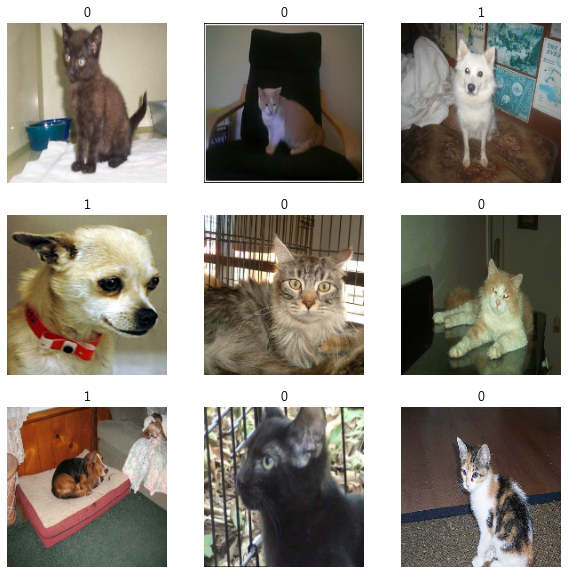

In [12]:
import matplotlib.pyplot as plt

# 顯示訓練資料前9筆影像
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## 定義資料增補(Data Augmentation)

In [15]:
# RandomFlip("horizontal")：水平翻轉
# RandomRotation(0.1)：旋轉 0.1 比例 
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## 顯示資料增補後的影像

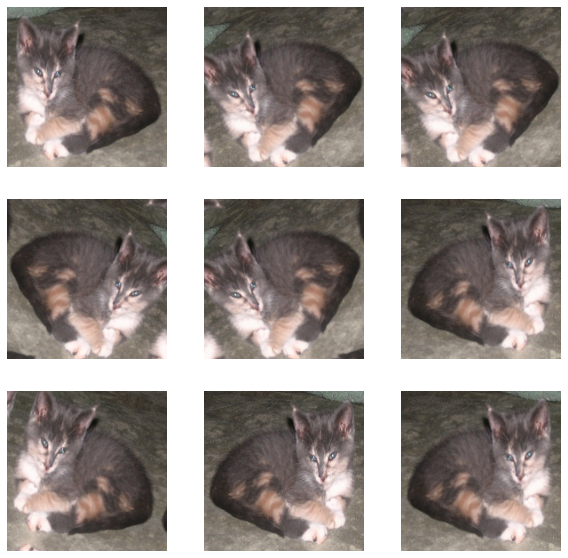

In [16]:
# 顯示資料增補後的影像
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## prefetch：預先讀取訓練資料，以提升效能

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## 建立模型

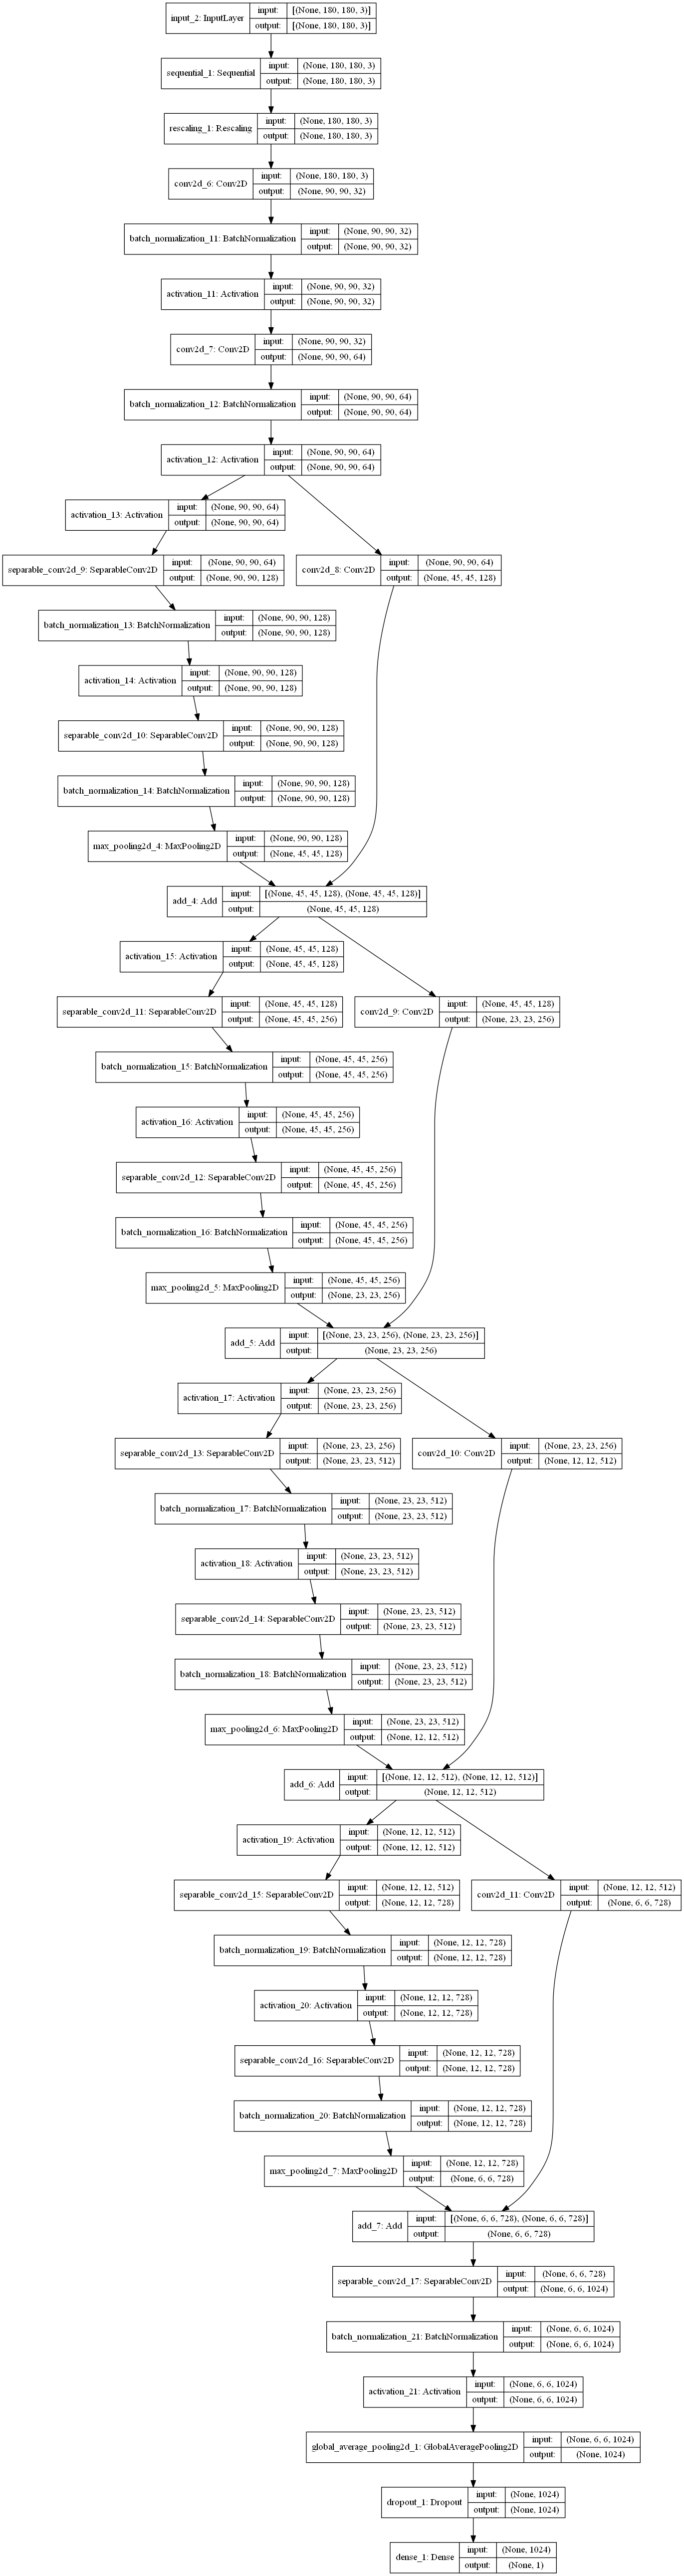

In [18]:
# 定義模型
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # 特徵縮放
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# 建立模型
model = make_model(input_shape=image_size + (3,), num_classes=2)
# 繪製模型結構
keras.utils.plot_model(model, show_shapes=True)

## 訓練模型

In [19]:
epochs = 5

# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# 模型訓練
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds
)

Epoch 1/5
586/586 [==============================] - 335s 559ms/step - loss: 0.6785 - accuracy: 0.6297 - val_loss: 0.8271 - val_accuracy: 0.5788
Epoch 2/5
586/586 [==============================] - 327s 557ms/step - loss: 0.5120 - accuracy: 0.7503 - val_loss: 0.4622 - val_accuracy: 0.7906
Epoch 3/5
586/586 [==============================] - 328s 558ms/step - loss: 0.4159 - accuracy: 0.8132 - val_loss: 0.6422 - val_accuracy: 0.7182
Epoch 4/5
586/586 [==============================] - 328s 558ms/step - loss: 0.3358 - accuracy: 0.8544 - val_loss: 0.3786 - val_accuracy: 0.8339
Epoch 5/5
586/586 [==============================] - 326s 556ms/step - loss: 0.2980 - accuracy: 0.8734 - val_loss: 0.6243 - val_accuracy: 0.7656


### 訓練 50 epochs，驗證準確率可達 96%.

## 從目錄中任選一個檔案測試

In [ ]:
# 模型存檔
model.save('./pet_model.h5')

In [ ]:
# 模型載入
model = tf.keras.models.load_model('./pet_model.h5')

In [22]:
# 任取一筆資料測試
img = keras.preprocessing.image.load_img(
    os.path.join(unzip_path, "PetImages/Cat/18.jpg"), target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img) # 將影像轉為陣列
img_array = tf.expand_dims(img_array, 0)  # 增加一維在最前面，代表一筆資料

predictions = model.predict(img_array)
score = predictions[0][0]
print(f"是貓的機率= {(100 * score):.2f}%")

是貓的機率= 97.27
